# Library packages and source functions

In [1]:
# omics
library(Signac)
library(Seurat)
library(SeuratDisk)
library(SummarizedExperiment)
library(GenomeInfoDb)

# plots
library(ggplot2)
library(RColorBrewer)
library(ComplexHeatmap)

# other
library(dplyr)
library(purrr)
library(Matrix)
library(data.table)
library(future)
library(pbapply)

# eSpatial functions
source('../R/functions.R')

Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
“package ‘matrixStats’ was built under R version 4.2.3”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, ro

# Input for eSpatial

The input matrixes of eSpatial contains spatial count matrix and spot coordinates matrix. We downloaded spatial chromatin accessibility profiling data from public literatures and generated spatial counts matrix for each dataset independently.

In [2]:
load("../Data/gr_embryos.Rdata") #gr
load("../Data/EnsDb.Mmusculus.v79.Rdata") #annotations

In [3]:
fragment <- "../Data/GSM6043255_ME11_20um_fragments.tsv.gz"
imagefile <-  "../Data/ME11_20um_spatial/"

In [4]:
sample = 'E11'
atac.frags = Signac::CreateFragmentObject(path = fragment)
counts = Signac::FeatureMatrix(fragments = atac.frags, features = gr)
atac.assay <- Signac::CreateChromatinAssay(
    counts = counts, 
    min.features = 0, 
    fragments = atac.frags
)
object <- Seurat::CreateSeuratObject(counts = atac.assay, assay = "peaks")
object$sample <- sample
Annotation(object) <- annotations

Computing hash

Extracting reads overlapping genomic regions

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_”


## add coordinates from image 

In [5]:
image <- Read10X_Image(image.dir = imagefile, filter.matrix = T)
coord <- image@coordinates
rownames(coord) <- paste0(rownames(coord), "-1") # RF data need
image@coordinates <- coord
cells <- rownames(coord)
image <- image[Cells(x = object)]
DefaultAssay(object = image) <- "Spatial"
object[["slice1"]] <- image
cod <- object@images$slice1@coordinates[,c("row", "col")]
colnames(cod) <- c("cod1", "cod2")
drobj <- CreateDimReducObject(
  embeddings = as.matrix(cod),
  key = "cod_"
)
object@reductions[["cod"]] <- drobj

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“No assay specified, setting assay as RNA by default.”


## calculate gene activity as RNA assay

In [6]:
DefaultAssay(object) <- "peaks"
Annotation(object) <- annotations
gene.activities <- GeneActivity(object)
genes <- rownames(gene.activities)
genes_filter <- c(grep("Pcdh", genes), grep("PCDH", genes),
                  grep("UGT", genes), grep("Ugt", genes),
                  grep("Gm", genes), grep("Rik", genes))
gene.activities_filtered <- gene.activities[-genes_filter,]
object[['RNA']] <- CreateAssayObject(counts = gene.activities_filtered)
object <- subset(object, cells = cells)

Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
“Adding image data that isn't associated with any assay present”


# Preprocess

## dimension reduction

eSpatial conducted dimension reduction for the gene-by-spot matrix and peak-by-spot matrix separately.

 For the gene-by-spot matrix, it employed principal component analysis (PCA) for dimensionality reduction and returned the top 20 principal components (PCs) matrix to generate a PC-by-spot matrix. 

In [7]:
#---RNA clustering 
DefaultAssay(object) <- "RNA"
object <- NormalizeData(object) %>% 
    FindVariableFeatures() %>% 
    ScaleData() %>% 
    RunPCA() %>% 
    RunUMAP(dims = 1:20) %>% 
    FindNeighbors(dims = 1:20) %>% 
    FindClusters()

object$seurat_clusters_rna <- paste0("R", object$seurat_clusters)
object$seurat_clusters_rna <- factor(object$seurat_clusters_rna, 
                                     levels = paste0("R", 0:length(object$seurat_clusters)))

Centering and scaling data matrix

PC_ 1 
Positive:  Gse1, Ncor2, Zmiz1, Msi2, Nfix, Rara, Casz1, Nol4l, Sept9, Bahcc1 
	   Bcor, Ccdc85c, Ptch1, Cuedc1, Cic, Ephb2, Macrod1, Notch1, Prdm16, Rai1 
	   Ssbp3, Tns1, Ski, Ptprs, Mnt, Ahdc1, Smad6, Anks1, Tcf7l1, Foxp4 
Negative:  Chl1, Skint6, Brinp3, Cdh12, Ncam2, Kcnh7, Galntl6.1, Kcnt2, Lrfn5, Cntn6 
	   Epha5, Luzp2, Cdh8, Trdn, Klhl1, Trhde, Ppfia2, Gabrb1, Spock3, Cdh7 
	   Ndst4, Olfm3, Hcn1, Khdrbs2, Dok6, Sfi1, Lrrc7, Cnbd1, Ano3, Ralyl 
PC_ 2 
Positive:  Uba7, Ntf3, Gpc3, Prrx2, Twist2, Gpr124, Synpo, Rarg, Wwp2, Ror2 
	   Rassf3, Col23a1, Rhoc, Cbfa2t3, Itga9, Tmem176a, Plac1, Lamc3, Wnt11, Col26a1 
	   Myh9, Myh6, Prdm16, Lsp1, Col5a1, Pcolce, Itga11, Alx4, Mdfi, Ece1 
Negative:  Celf4, Kcnk10, Srgap3, Srrm4, Nxph1, Ttyh1, Ephb1, Nrcam, Lfng, Nova2 
	   Cdh22, Ildr2, Atp11c, Dtx4, Bai1, Map1b, Mageb18, Sox1, Nkx2-2, Rgma 
	   Lhcgr, Btbd17, Cxxc4, Ntn1, Nuak2, Tppp3, Snrpn.1, Rhbdl3, Gpm6b, Elavl3 
PC_ 3 
Positive:  Gpc3, Plac

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2099
Number of edges: 107114

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7519
Number of communities: 6
Elapsed time: 0 seconds


For the peak-by-spot matrix, eSpatial adopted an iterative latent semantic indexing (LSI) approach to reduce dimensions and returned the top 20 LSI matrix to generate an LSI-by-spot matrix, excluding the foremost LSI corresponding to sequencing depth variation.

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
“Some features contain 0 total counts”
Running SVD

Scaling cell embeddings

09:55:56 UMAP embedding parameters a = 0.9922 b = 1.112

09:55:56 Read 2099 rows and found 19 numeric columns

09:55:56 Using Annoy for neighbor search, n_neighbors = 30

09:55:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:55:56 Writing NN index file to temp file /tmp/RtmpVNNL4c/file26ab92d14ed9d

09:55:56 Searching Annoy index using 1 thread, search_k = 3000

09:55:57 Annoy recall = 100%

09:55:58 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

09:55:59 Initializing from normalized Laplacian + noise (using irlba)

09:5

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2099
Number of edges: 93949

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.8137
Number of communities: 11
Elapsed time: 0 seconds


2 singletons identified. 9 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2099
Number of edges: 93949

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8570
Number of communities: 10
Elapsed time: 0 seconds


2 singletons identified. 8 final clusters.



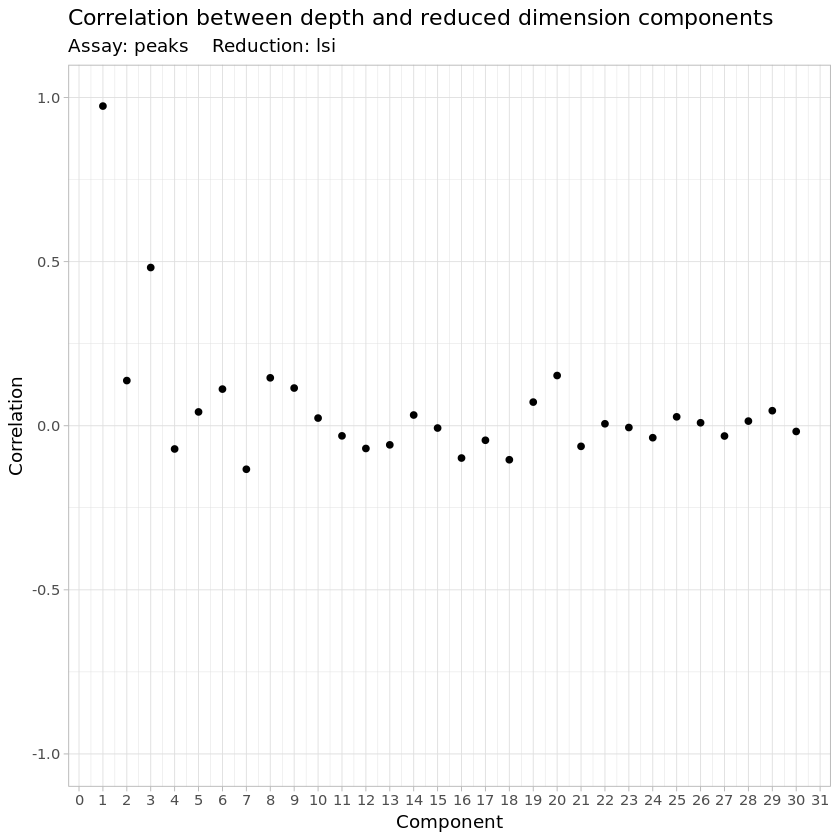

In [8]:
#---ATAC clustering 
DefaultAssay(object) <- "peaks"
object <- FindTopFeatures(object, min.cutoff = 10)
object <- RunTFIDF(object)
object <- RunSVD(object)
DepthCor(object, n = 30)
object <- RunUMAP(object, reduction = 'lsi', dims = 2:20) %>% 
    FindNeighbors(reduction = 'lsi', dims = 2:20) %>% 
    FindClusters(algorithm = 3) 

object <- FindClusters(object, resolution = 0.5) 
object$seurat_clusters_atac <- paste0("A", object$seurat_clusters)
object$seurat_clusters_atac <- factor(object$seurat_clusters_atac,
                                      levels = paste0("A", 0:length(unique(object$seurat_clusters_atac))))

eSpatial utilizes the FindMultiModalNeighbors() function from Seurat to create a weighted nearest neighbor (WNN) graph. This approach is employed to construct a joint neighbor graph incorporating both assays, and the results are visualized for analysis.

In [9]:
# build a joint neighbor graph using both assays
object <- FindMultiModalNeighbors(
    object = object, 
    reduction.list = list("pca", "lsi"), 
    dims.list = list(1:20, 2:20), 
    modality.weight.name = "peak.weight", 
    verbose = TRUE
)

# build a joint UMAP visualization
object <- RunUMAP(
    object = object, 
    nn.name = "weighted.nn", 
    assay = "peaks", 
    verbose = TRUE
)

object <- FindClusters(object, graph.name = "wsnn", algorithm = 3, resolution = 0.5)
object$seurat_clusters_joint <- paste0("J", object$seurat_clusters)
object$seurat_clusters_joint <- factor(object$seurat_clusters_joint, 
                                       levels = paste0("J", 0:length(object$seurat_clusters_joint)))

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Warning message in FindMultiModalNeighbors(object = object, reduction.list = list("pca", :
“The number of provided modality.weight.name is not equal to the number of modalities. RNA.weight peaks.weight are used to store the modality weights”
Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

09:56:13 UMAP embedding parameters a = 0.9922 b = 1.112

09:56:13 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

09:56:15 Initializing from normalized Laplacian + noise (using irlba)

09:56:15 Commencing optimization for 500 epochs, with 68476 positive edges

09:56:23 Optimization finished



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2099
Number of edges: 111397

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.8888
Number of communities: 8
Elapsed time: 0 seconds


Save the file and convert it to .h5ad format for subsequent analysis in scanpy.

In [10]:
#---RNA
DefaultAssay(object) <- "RNA"
sub <- DietSeurat(object, assays = "RNA")
meta <- sub@meta.data
meta <- meta[,c("nCount_peaks", "nFeature_peaks", "seurat_clusters_rna", "seurat_clusters_atac", "seurat_clusters_joint")]
coord <- object@reductions$cod@cell.embeddings
meta <- cbind(meta, coord)
sub@meta.data <- meta

In [11]:
SaveH5Seurat(sub, filename = "../outs/E11_PCA.h5Seurat", overwrite = T)
Convert("../outs/E11_PCA.h5Seurat", "../outs/E11_PCA.h5ad", overwrite = T)

Warning message:
“Overwriting previous file ../outs/E11_PCA.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

Adding variable features for RNA

Adding feature-level metadata for RNA

Adding image slice1

Validating h5Seurat file

Warning message:
“Cannot find assay Spatial in the H5Seurat file”
Adding data from RNA as X

Transfering meta.features to var

Adding counts from RNA as raw

Transfering meta.features to raw/var

Transfering meta.data to obs



In [12]:
#---ATAC
mat <- object@reductions$lsi@cell.embeddings[,2:50]
assay <- CreateAssayObject(counts = mat)
sub <- CreateSeuratObject(counts = t(mat),
                         meta.data = meta)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [13]:
SaveH5Seurat(sub, filename = "../outs/E11_LSI_-1.h5Seurat", overwrite = T)
Convert("../outs/E11_LSI_-1.h5Seurat", "../outs/E11_LSI_-1.h5ad", overwrite = T)

Warning message:
“Overwriting previous file ../outs/E11_LSI_-1.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Validating h5Seurat file

Adding data from RNA as X

Adding counts from RNA as raw

Transfering meta.data to obs



In [14]:
#---joint
mat1 <- object@reductions$lsi@cell.embeddings[,2:50]
mat2 <- object@reductions$pca@cell.embeddings[,1:50]
mat <- cbind(mat1, mat2)
assay <- CreateAssayObject(counts = mat)
sub <- CreateSeuratObject(counts = t(mat),
                         meta.data = meta)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [15]:
SaveH5Seurat(sub, filename <- "../outs/E11_PCA_LSI.h5Seurat", overwrite = T)
Convert("../outs/E11_PCA_LSI.h5Seurat", "../outs/E11_PCA_LSI.h5ad", overwrite = T)

Warning message:
“Overwriting previous file ../outs/E11_PCA_LSI.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Validating h5Seurat file

Adding data from RNA as X

Adding counts from RNA as raw

Transfering meta.data to obs

